In [1]:
pip install psycopg2-binary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
## Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.io.sql as sqlio
import psycopg2 as ps
import warnings 
warnings.filterwarnings("ignore")

In [2]:
conn = ps.connect(dbname="Northwind",
                  user="postgres",
                  password="Data466",
                  port = "5432")

In [3]:
Ship_df="""WITH Shipping_Analysis AS
(
    SELECT
        ship_country,
        order_id,
        order_date,
        required_date,
        shipped_date,
        (EXTRACT(EPOCH FROM age(shipped_date, order_date)) / 86400)::integer AS shipping_time,
        (EXTRACT(EPOCH FROM AGE(required_date, shipped_date)) / 86400)::integer AS delay_time,
        freight,
        SUM(freight) OVER() AS total_shipping_cost
    FROM orders
)
SELECT 
    ship_country,
    COUNT(DISTINCT order_id) AS total_order,
    ROUND(AVG(shipping_time)::decimal,2) AS avg_shipping_time,
    ROUND(SUM(freight)::decimal,2) AS total_shipping_cost
FROM Shipping_Analysis
GROUP BY ship_country;"""




In [4]:
df = sqlio.read_sql_query(Ship_df,conn)
df.head(10)


,ship_country,total_order,avg_shipping_time,total_shipping_cost
0,Argentina,16,9.29,598.58
1,Austria,40,8.71,7391.50
2,Belgium,19,9.16,1280.14
3,Brazil,83,8.10,4880.19
4,Canada,30,5.93,2198.09
5,Denmark,18,7.41,1396.19
6,Finland,22,5.59,910.89
7,France,77,8.43,4237.84
8,Germany,122,8.00,11283.30
9,Ireland,19,10.95,2755.24


In [5]:
shipping_country=df.sort_values(by='total_shipping_cost',ascending=False).head(10).reset_index()
shipping_country

,index,ship_country,total_order,avg_shipping_time,total_shipping_cost
0,19,USA,122,9.55,13771.30
1,8,Germany,122,8.00,11283.30
2,1,Austria,40,8.71,7391.50
3,3,Brazil,83,8.10,4880.19
4,7,France,77,8.43,4237.84
5,16,Sweden,37,10.19,3237.60
6,18,UK,56,8.20,2954.27
7,9,Ireland,19,10.95,2755.24
8,20,Venezuela,46,8.44,2735.18
9,4,Canada,30,5.93,2198.09


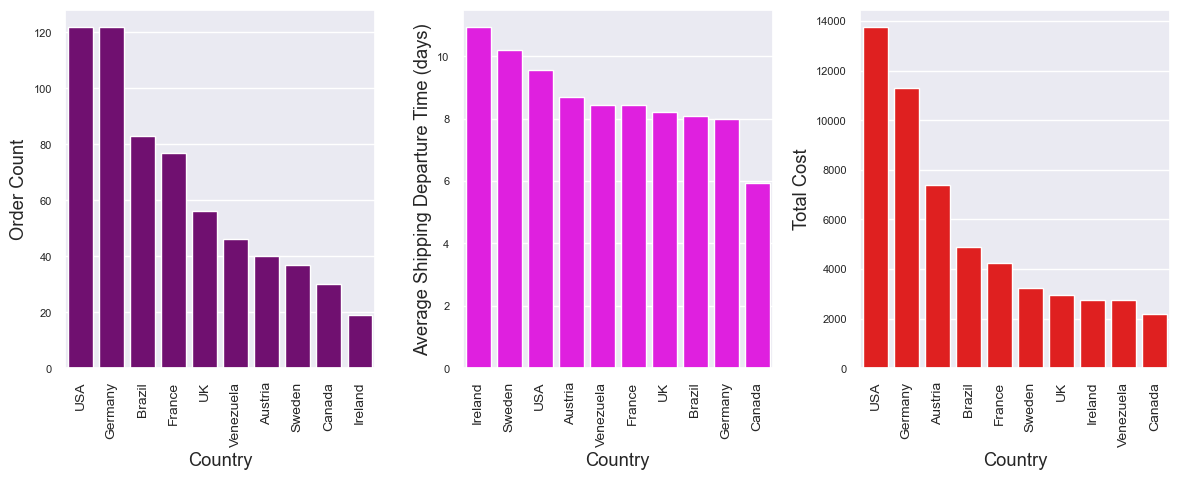

In [7]:
# Countries Based on Shipping Cost, Order Count, and Average Shipping Time
sns.set_theme(font_scale=1.1)
## Based on Total Order Count:
plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.barplot(x='ship_country',y='total_order',data=shipping_country.sort_values(by='total_order',ascending=False),color='purple')
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=8,rotation=0)
plt.xlabel('Country')
plt.ylabel('Order Count')

## Based on Average Shipping Time (in Days):
plt.subplot(1, 3, 2)
sns.barplot(x='ship_country',y='avg_shipping_time',data=shipping_country.sort_values(by='avg_shipping_time',ascending=False),color='fuchsia')
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=8,rotation=0)
plt.xlabel('Country')
plt.ylabel('Average Shipping Departure Time (days)')

## Based on Total Shipping Costs:
plt.subplot(1, 3, 3)
sns.barplot(x='ship_country',y='total_shipping_cost',data=shipping_country.sort_values(by='total_shipping_cost',ascending=False),color='red')
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=8,rotation=0)
plt.xlabel('Country')
plt.ylabel('Total Cost')

plt.tight_layout()
plt.show()

In [8]:
Unreliable_orders="""WITH Shipping_Analysis AS
(
    SELECT
        s.company_name,
        o.order_id,
        o.required_date - o.shipped_date AS delay_time
    FROM orders o
    LEFT JOIN shippers s ON o.ship_via = s.shipper_id
)
SELECT 
    company_name,
    COUNT(DISTINCT order_id) AS total_order_count,
    COUNT(DISTINCT CASE WHEN delay_time < 3 OR delay_time IS NULL THEN order_id END) AS unreliable_orders
FROM Shipping_Analysis
GROUP BY company_name;"""

In [9]:
u_df = sqlio.read_sql_query(Unreliable_orders,conn)
u_df.head(10)


,company_name,total_order_count,unreliable_orders
0,Federal Shipping,255,17
1,Speedy Express,249,17
2,United Package,326,33


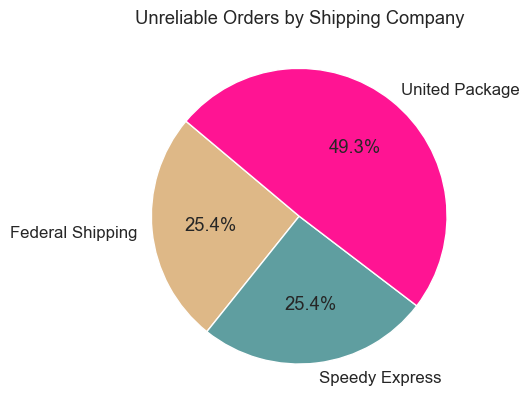

In [10]:
## Unreliable Orders: Orders with null values, delayed, or at risk of being delayed.
## At-Risk Orders: Orders that haven't been shipped at least 3 days before the expected delivery date.
labels = u_df['company_name']
sizes = u_df['unreliable_orders']
colors = ['#DEB887','#5F9EA0','#FF1493']  

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
##ax.axis('equal') 

plt.title('Unreliable Orders by Shipping Company')
plt.show()

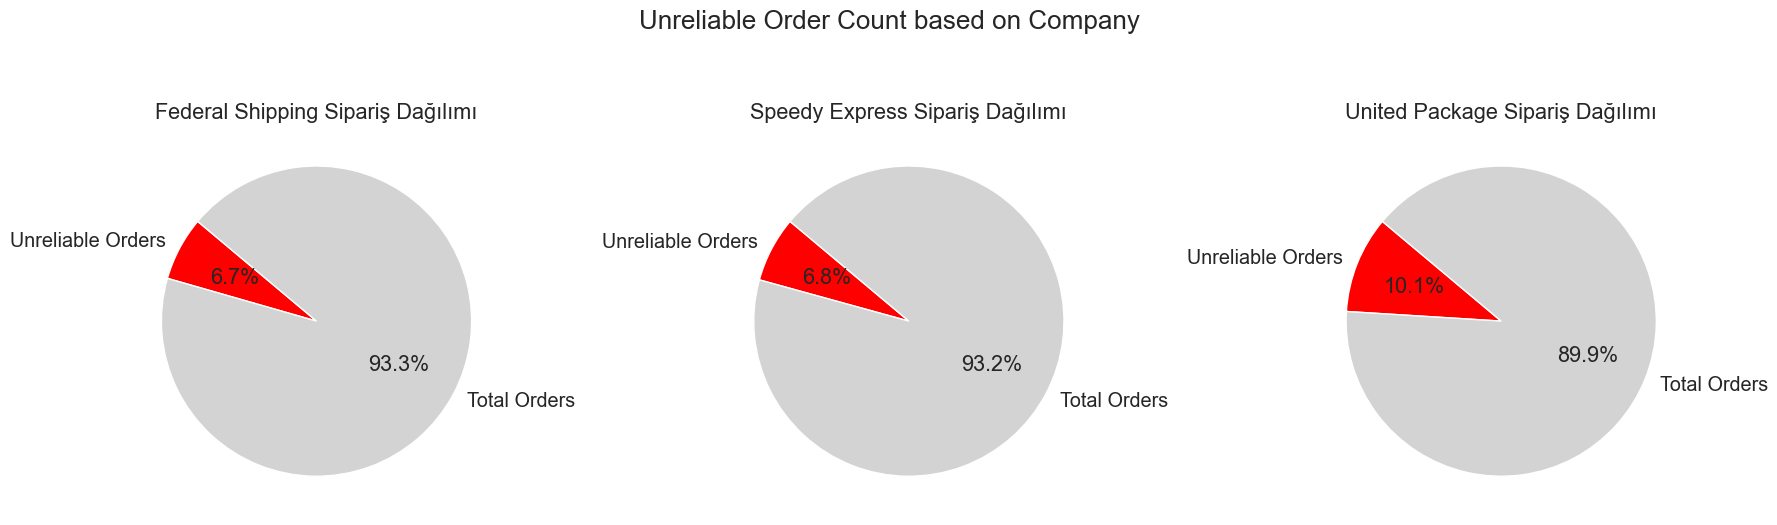

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme(font_scale=1.3)
for ax, (index, row) in zip(axes, u_df.iterrows()):
    company_name = row['company_name']
    total_orders = row['total_order_count']
    unreliable_orders = row['unreliable_orders']
    
    # Calculate percanteges:
    sizes = [unreliable_orders, total_orders - unreliable_orders]
    labels = ['Unreliable Orders', 'Total Orders']
    colors = ['red', 'lightgray']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'{company_name} Sipariş Dağılımı')
    

plt.suptitle('Unreliable Order Count based on Company')
plt.tight_layout()
plt.show()

In [13]:
Stock_Analysis="""SELECT
    product_id,
    product_name,
    unit_in_stock,
    unit_on_order,
    reorder_level,
    reorder_level - unit_in_stock AS StockDeficit
FROM products
WHERE unit_in_stock < reorder_level AND discontinued = 0;"""



In [14]:
# Ranked List of Products with Insufficient Stock: 
dfs = sqlio.read_sql_query(Stock_Analysis,conn)
dfs=dfs.sort_values(by='stockdeficit',ascending=True)
dfs

,product_id,product_name,unit_in_stock,unit_on_order,reorder_level,stockdeficit
16,74,Longlife Tofu,4,20,5,1
2,21,Sir Rodney's Scones,3,40,5,2
3,30,Nord-Ost Matjeshering,10,0,15,5
10,49,Maxilaku,10,60,15,5
1,11,Queso Cabrales,22,30,30,8
12,64,Wimmers gute Semmelknödel,22,80,30,8
7,43,Ipoh Coffee,17,10,25,8
14,68,Scottish Longbreads,6,10,15,9
11,56,Gnocchi di nonna Alice,21,10,30,9
8,45,Rogede sild,5,70,15,10


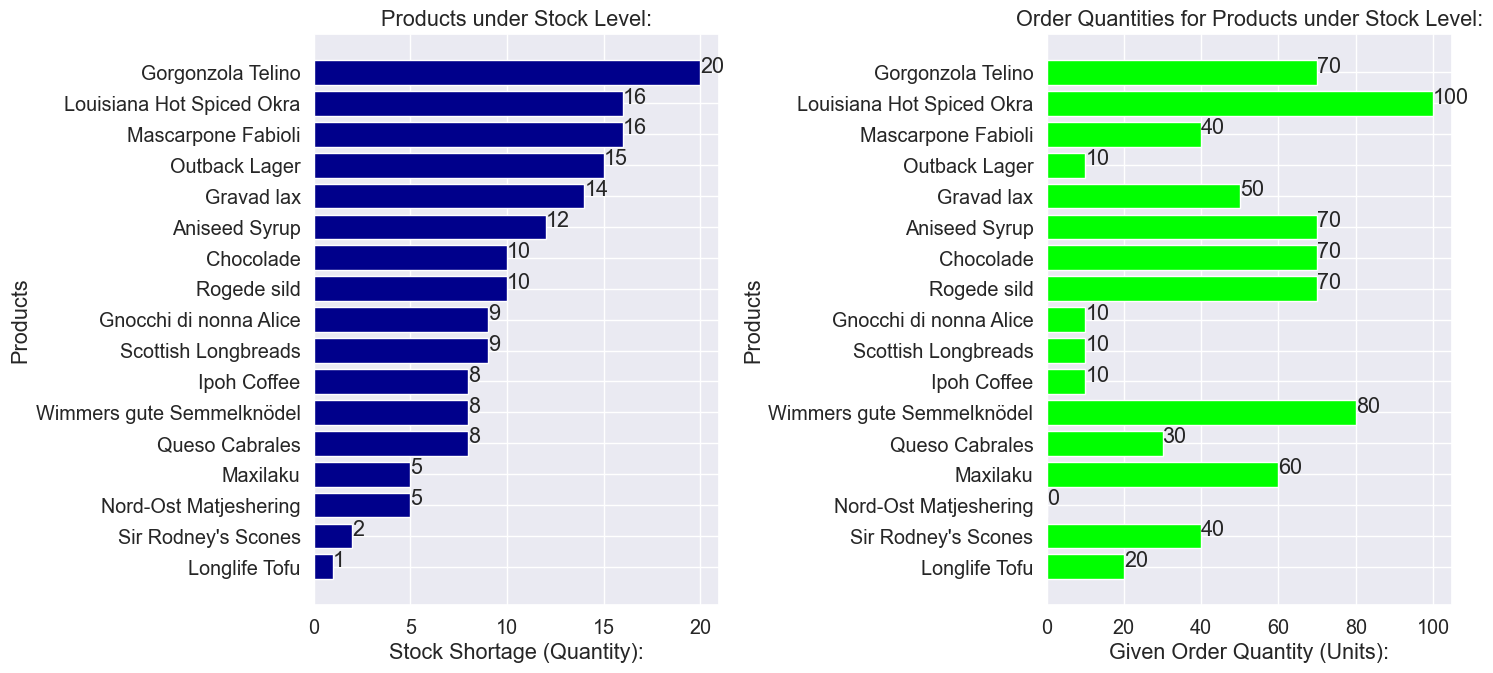

In [15]:

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
plt.figure(figsize=(15,7))
# Stock Shortage Chart
plt.subplot(1, 2, 1)
y=dfs['stockdeficit']
x=dfs['product_name']
plt.barh(x,y,color='darkblue')
plt.xlabel('Stock Shortage (Quantity):')
plt.ylabel('Products')
plt.title('Products under Stock Level:')
for index, value in enumerate(y):
     plt.text(value,index,
            str(value))

# Order Quantity Chart (Units On Order):
plt.subplot(1, 2, 2)
y=dfs['unit_on_order']
x=dfs['product_name']
plt.barh(x,y,color='lime')
plt.xlabel('Given Order Quantity (Units):')
plt.ylabel('Products')
plt.title('Order Quantities for Products under Stock Level:')
for index, value in enumerate(y):
     plt.text(value,index,
            str(value))
plt.tight_layout()
plt.show()



In [16]:
# Products with Insufficient Stock and Insufficient Order Quantity:
Stock_Analysis2="""SELECT
    product_id,
    product_name,
    unit_in_stock,
    unit_on_order,
    reorder_level,
    discontinued
FROM products
WHERE (unit_in_stock + unit_on_order) < reorder_level
    AND discontinued = 0;"""

In [17]:
dfe = sqlio.read_sql_query(Stock_Analysis2,conn)
dfe

,product_id,product_name,unit_in_stock,unit_on_order,reorder_level,discontinued
0,30,Nord-Ost Matjeshering,10,0,15,0
1,70,Outback Lager,15,10,30,0


In [18]:
## List of Discontinued Products and Remaining Quantities:
Stock_Analysis_3="""SELECT
    product_id,
    product_name,
    unit_in_stock,
    unit_on_order,
    reorder_level,
    unit_price,
    ROUND((unit_in_stock + unit_on_order) * unit_price::decimal, 2) AS loss,
    discontinued
FROM products
WHERE discontinued = 1;"""


In [19]:

dfk = sqlio.read_sql_query(Stock_Analysis_3,conn)
dfk

,product_id,product_name,unit_in_stock,unit_on_order,reorder_level,unit_price,loss,discontinued
0,1,Chai,39,0,10,18.00,702.0,1
1,2,Chang,17,40,25,19.00,1083.0,1
2,5,Chef Anton's Gumbo Mix,0,0,0,21.35,0.0,1
3,9,Mishi Kobe Niku,29,0,0,97.00,2813.0,1
4,17,Alice Mutton,0,0,0,39.00,0.0,1
5,24,Guaraná Fantástica,20,0,0,4.50,90.0,1
6,28,Rössle Sauerkraut,26,0,0,45.60,1185.6,1
7,29,Thüringer Rostbratwurst,0,0,0,123.79,0.0,1
8,42,Singaporean Hokkien Fried Mee,26,0,0,14.00,364.0,1
9,53,Perth Pasties,0,0,0,32.80,0.0,1


In [20]:
dfk2=dfk[dfk['loss']>0]
dfk2

,product_id,product_name,unit_in_stock,unit_on_order,reorder_level,unit_price,loss,discontinued
0,1,Chai,39,0,10,18.0,702.0,1
1,2,Chang,17,40,25,19.0,1083.0,1
3,9,Mishi Kobe Niku,29,0,0,97.0,2813.0,1
5,24,Guaraná Fantástica,20,0,0,4.5,90.0,1
6,28,Rössle Sauerkraut,26,0,0,45.6,1185.6,1
8,42,Singaporean Hokkien Fried Mee,26,0,0,14.0,364.0,1


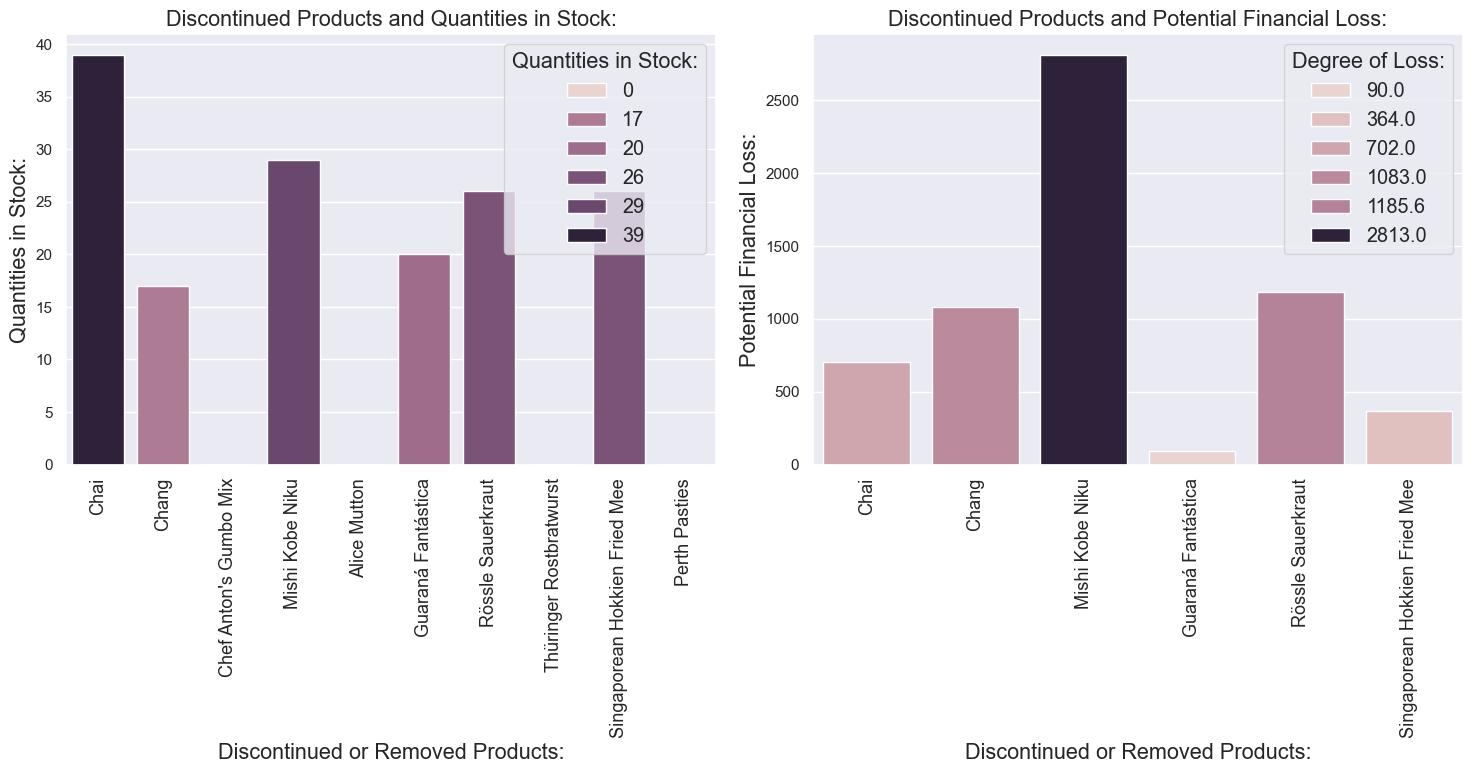

In [21]:

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
sns.barplot(x=dfk["product_name"], y=dfk["unit_in_stock"], hue=dfk["unit_in_stock"])
plt.xticks(fontsize=10,rotation=90)
plt.xlabel('Discontinued or Removed Products:')
plt.ylabel('Quantities in Stock:')
plt.title('Discontinued Products and Quantities in Stock:')
plt.legend(title='Quantities in Stock:')  
plt.yticks(fontsize=11,rotation=0)
plt.xticks(fontsize=13,rotation=90)


plt.subplot(1, 2, 2)
sns.barplot(x=dfk2["product_name"], y=dfk2["loss"], hue=dfk2["loss"])
plt.xticks(fontsize=10,rotation=90)
plt.xlabel('Discontinued or Removed Products:')
plt.ylabel('Potential Financial Loss:')
plt.title('Discontinued Products and Potential Financial Loss:')
plt.legend(title='Degree of Loss:')  
plt.yticks(fontsize=11,rotation=0)
plt.xticks(fontsize=13,rotation=90)
plt.tight_layout()
plt.show()
